In [1]:
from pathlib import Path
from anndata import read_h5ad

import sys
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

from tqdm import tqdm
from scipy import stats
import pickle
import anndata as ad
from scipy.stats import zscore
from PIL import Image
from stimage._utils import gene_plot
import seaborn as sns

In [2]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [3]:
PATH_PRED = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage_exp/ST_pred_her2")
PATH_GC = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage_exp/ST_pred_her2")
OUT_PATH = PATH_PRED / "PLOT"
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
adata_dict = {}
for file_path in PATH_PRED.glob("./pred*.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    adata = ad.read_h5ad(file_path)
    adata_dict[library_id] = adata

In [5]:
gc_adata = ad.read_h5ad(PATH_GC / "gt_A1.h5ad")
gene_list_st = gc_adata.var_names

In [6]:
len(gene_list_st)

11871

In [7]:
adata_dict

{'D2': AnnData object with n_obs × n_vars = 283 × 1522
     obs: 'imagecol', 'imagerow', 'tile_path', 'tile_tissue_mask_path', 'tissue_area', 'library_id'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'B1': AnnData object with n_obs × n_vars = 261 × 1522
     obs: 'imagecol', 'imagerow', 'tile_path', 'tile_tissue_mask_path', 'tissue_area', 'library_id'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'F2': AnnData object with n_obs × n_vars = 672 × 1522
     obs: 'imagecol', 'imagerow', 'tile_path', 'tile_tissue_mask_path', 'tissue_area', 'library_id'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'A6': AnnData object with n_obs × n_vars = 298 × 1522
     obs: 'imagecol', 'imagerow', 'tile_path', 'tile_tissue_mask_path', 'tissue_area', 'library_id'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 'C4': AnnData object with n_obs × n_vars = 168 × 1522
     obs: 'imagecol', 'imagerow', 'tile_path', 'tile_tissue_mask_path', 'tissue_area'

In [8]:
# with open(PATH_PRED / "xenium_gene_list.pkl", "rb") as f:
#     gene_list_xenium = pickle.load(f)

In [9]:
common_genes = list(set(gene_list_st) & set(adata.var_names))
len(common_genes)

1146

In [14]:
# gene_to_plot = ["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]
gene_to_plot = ['B2M', 'HLA-DRA']
for library_id, adata in adata_dict.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 0.1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0]//10, hires.size[1]//10))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        if gene in common_genes:
            gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=100,
                            output=str(OUT_PATH), name=f"pred_{library_id}_{gene}.pdf")
            plt.close()


In [14]:
# hi-res
# gene_to_plot = ["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]
gene_to_plot = ['B2M', 'HLA-DRA']
for library_id, adata in adata_dict.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    # hires.thumbnail((hires.size[0], hires.size[1]))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        if gene in common_genes:
            fig = gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=50)
            fig.savefig(OUT_PATH / f"hires_pred_{library_id}_{gene}.png", dpi=2000)
            plt.close()

In [11]:
OUT_PATH

PosixPath('/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Working_project/STimage_exp/ST_pred_her2/PLOT')

In [15]:
for file_path in PATH_PRED.glob("./gt*.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    adata_gt = ad.read_h5ad(file_path)
    adata_gt = adata_gt[:, common_genes]
    adata_gt.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 0.1}
    hires = Image.fromarray(adata_gt.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0]//10, hires.size[1]//10))
    adata_gt.uns["spatial"][library_id]["images"]["hires"] = hires
    adata_gt.X = adata_gt.to_df().apply(zscore)
    for gene in gene_to_plot:
        if gene in common_genes:
            gene_plot(adata_gt, genes=gene, image_scale=True, library_id=library_id, spot_size=100,
                            output=str(OUT_PATH), name=f"gt_{library_id}_{gene}.pdf")
            plt.close()


In [15]:
# hires
for file_path in PATH_PRED.glob("./gt*.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    adata_gt = ad.read_h5ad(file_path)
    adata_gt = adata_gt[:, common_genes]
    adata_gt.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 1}
    hires = Image.fromarray(adata_gt.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0], hires.size[1]))
    adata_gt.uns["spatial"][library_id]["images"]["hires"] = hires
    adata_gt.X = adata_gt.to_df().apply(zscore)
    for gene in gene_to_plot:
        if gene in common_genes:
            fig = gene_plot(adata_gt, genes=gene, image_scale=True, library_id=library_id, spot_size=50)
            fig.savefig(OUT_PATH / f"hires_gt_{library_id}_{gene}.png", dpi=2000)
            plt.close()

In [10]:
def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

In [87]:
df = pd.DataFrame()
for file_path in PATH_PRED.glob("./gt*.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    print(library_id)
    adata_gt = ad.read_h5ad(file_path)
    sc.pp.normalize_total(adata_gt)
    sc.pp.log1p(adata_gt)
    adata_gt = adata_gt[:, common_genes]
    adata_true = adata_dict[library_id]
    for gene in common_genes:
        cor_val = calculate_correlation(adata_gt.to_df().loc[:,gene], adata_true.to_df().loc[:,gene])
        df = pd.concat([df, pd.DataFrame([gene, cor_val, library_id, "STimage_her2st"],
                            index=["Gene", "Pearson correlation", "Slide", "Method"]).transpose()], ignore_index=True, axis=0)
    

H1


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


C2
C1
D2


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


A5


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

E2


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


H2


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


C4


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


A1


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

A3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

A2
E3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

C6


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


B5


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


D1
B1


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


D5


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


H3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

F1


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


B6


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


F2


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


F3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


D4
C3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


A4


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

G3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

B3


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/li

B2


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


B4


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


C5


/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/uqxtan9/micromamba/envs/stimage/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


D3
G1


: 

In [75]:
df.to_csv(OUT_PATH / "correlation.csv")

In [10]:
df = pd.read_csv(OUT_PATH / "correlation.csv")

In [11]:
top_300gene = df.groupby("Gene")["Pearson correlation"].mean().sort_values(ascending=False)[0:300].index
df_top300 = df[df["Gene"].isin(top_300gene)]


In [12]:
top_300gene[0:20]

Index(['B2M', 'HLA-DRA', 'XBP1', 'PDIA6', 'AKT1', 'MCL1', 'FN1', 'PDIA4',
       'CD99', 'CTSB', 'CDH1', 'DDX3X', 'CTNNA1', 'ERBB2', 'TAPBP', 'HSPB1',
       'PFN1', 'EFNA1', 'IDH2', 'CD164'],
      dtype='object', name='Gene')

In [16]:
df_top300 = df_top300.sort_values("Slide", ascending=True)

In [20]:
ax, fig = plt.subplots(figsize=(10,6))
sns.boxplot(x="Slide", y="Pearson correlation", data=df_top300)
# plt.ylim(0,1)
plt.savefig(OUT_PATH / "top_100gene.pdf")

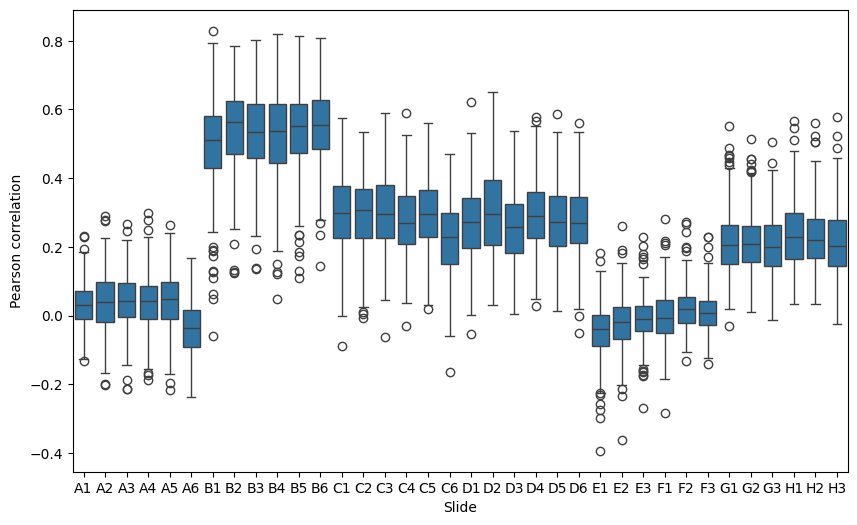

In [18]:
plt.show()